The following notebook contains ML methods with 2 correlating variables: junction count and psi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, GridSearchCV

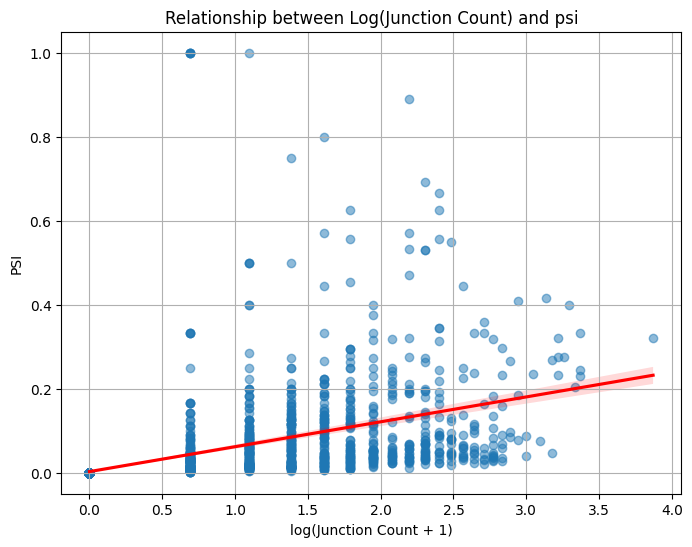

In [5]:
'''
Correlation between junction count and psi
'''

df = pd.read_csv('unfiltered_cryptic_data.csv')

df['log_junction_count'] = np.log1p(df['junction_count'])

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    x='log_junction_count',
    y='psi',
    data=df,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title("Relationship between Log(Junction Count) and psi")
plt.xlabel("log(Junction Count + 1)")
plt.ylabel("PSI")
plt.grid(True)
plt.show()

Confusion Matrix:
 [[319   1]
 [  0 172]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       0.99      1.00      1.00       172

    accuracy                           1.00       492
   macro avg       1.00      1.00      1.00       492
weighted avg       1.00      1.00      1.00       492

Feature Importance:
psi_scaled: 0.0870
sample_name_201903_M337P_neg_siT_2: 0.0413
sample_name_201903_Q331K_neg_siT_1: 0.0412


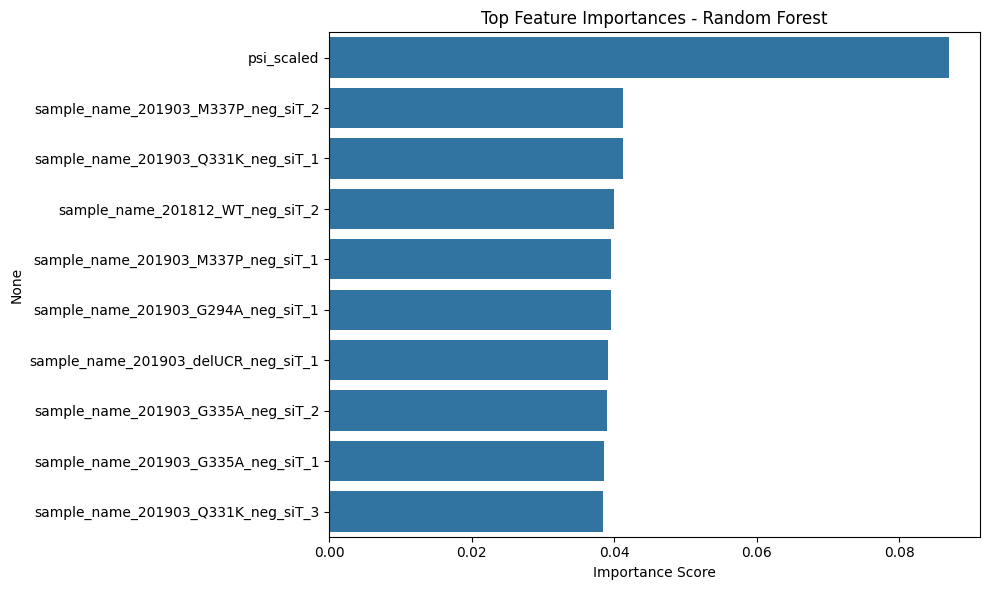

In [23]:
'''
Random Forest Model to nonlinear classification, using the outcome 'rescueExpression' as the categorical target.
'''

# Load data and clean up
df = pd.read_csv('unfiltered_cryptic_data.csv')
df = df[["psi","junction_coords","sample_name","rescueExpression"]]

df["psi"] = df["psi"].fillna(0)
scaler = StandardScaler()
df["psi_scaled"] = scaler.fit_transform(df[["psi"]])
df = df.drop(columns=["psi"])

# Encode target column
df["rescueExpression"] = LabelEncoder().fit_transform(df["rescueExpression"])

# Encode variables
categorical_cols = ['junction_coords', "sample_name"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

X = df.drop(columns=["rescueExpression"])
y = df["rescueExpression"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_ranking = sorted(zip(feature_names, importances), key=lambda x: -x[1])
print("Feature Importance:")
for feature, score in feature_ranking[:3]:
    print(f"{feature}: {score:.4f}")

top_n = 10
top_features = pd.Series(importances, index=feature_names).nlargest(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


Psi shown here to be the most important for predicting Rescue Expression (cryptic splicing respression)

In [ ]:
"""
Correlating top features with metadata - (e.g. TDP43_kd)

"""





Confusion Matrix:
 [[315   2]
 [  0 172]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       317
           1       0.99      1.00      0.99       172

    accuracy                           1.00       489
   macro avg       0.99      1.00      1.00       489
weighted avg       1.00      1.00      1.00       489



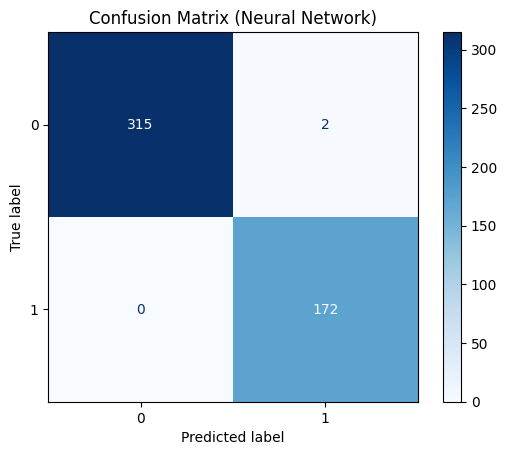

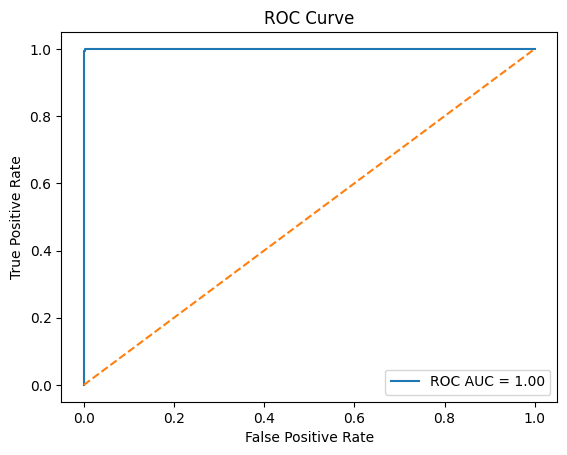

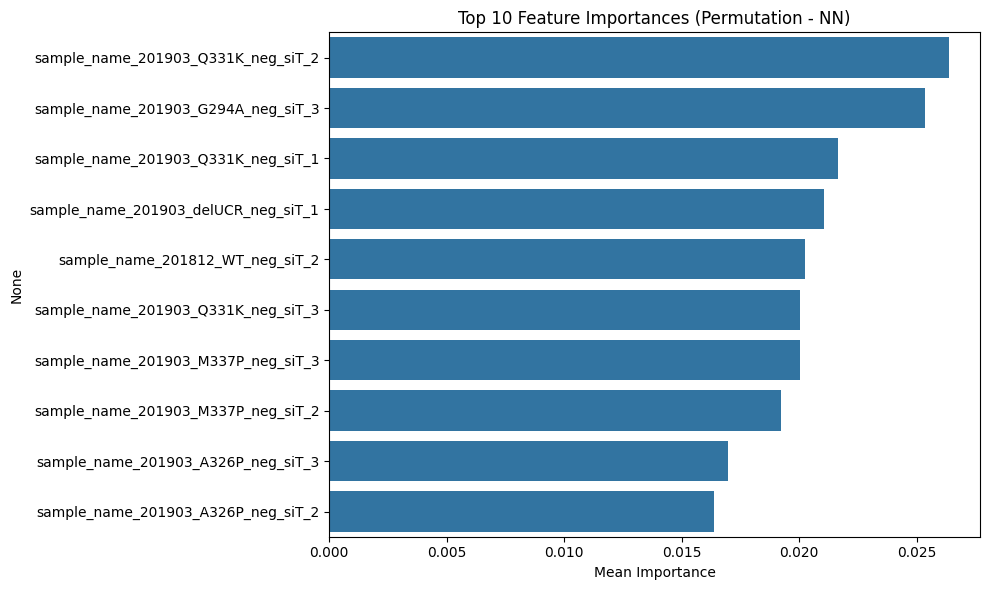

In [2]:
"""
Neural Network - MLPClassifier - nonlinear classification
"""


df = pd.read_csv('unfiltered_cryptic_data.csv')

# Keep relevant columns
df = df[['psi', 'junction_coords', 'sample_name', 'rescueExpression']]

# Drop missing values
df = df.dropna(subset=['psi', 'junction_coords', 'sample_name', 'rescueExpression'])

# Encode target variable
le = LabelEncoder()
df['rescueExpression'] = le.fit_transform(df['rescueExpression'])

# Encode categorical features (except psi, which is continuous)
df = pd.get_dummies(df, columns=['junction_coords', 'sample_name'], drop_first=True)

# Scale psi
scaler = StandardScaler()
df['psi'] = scaler.fit_transform(df[['psi']])

# Split features/labels
X = df.drop(columns=['rescueExpression'])
y = df['rescueExpression']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Train Neural Network ---
model = MLPClassifier(hidden_layer_sizes=(30, 15), alpha=0.01, max_iter=300, early_stopping=True, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# --- Evaluation ---
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion matrix plot ---
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix (Neural Network)")
plt.show()

# --- ROC Curve (if binary classification) ---
if len(le.classes_) == 2:
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# --- Permutation Feature Importance ---
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-10:][::-1]  # Top 10

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance.importances_mean[sorted_idx], y=X.columns[sorted_idx])
plt.title("Top 10 Feature Importances (Permutation - NN)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()

Confusion Matrix showed that the initial model had perfect classification accuracy, which suggests overfitting. The model complexity was reduced and regularisation was increased. 

Best Params: {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,)}
Confusion Matrix (Best Model):
 [[317   0]
 [  0 172]]

Classification Report (Best Model):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00       172

    accuracy                           1.00       489
   macro avg       1.00      1.00      1.00       489
weighted avg       1.00      1.00      1.00       489



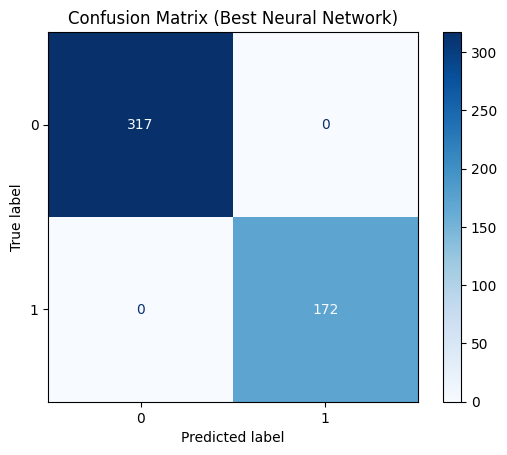

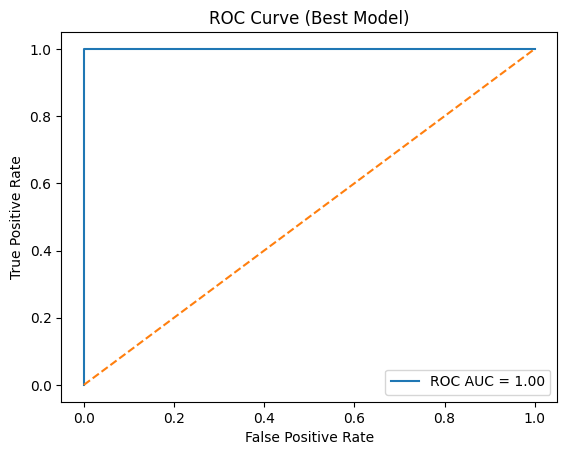

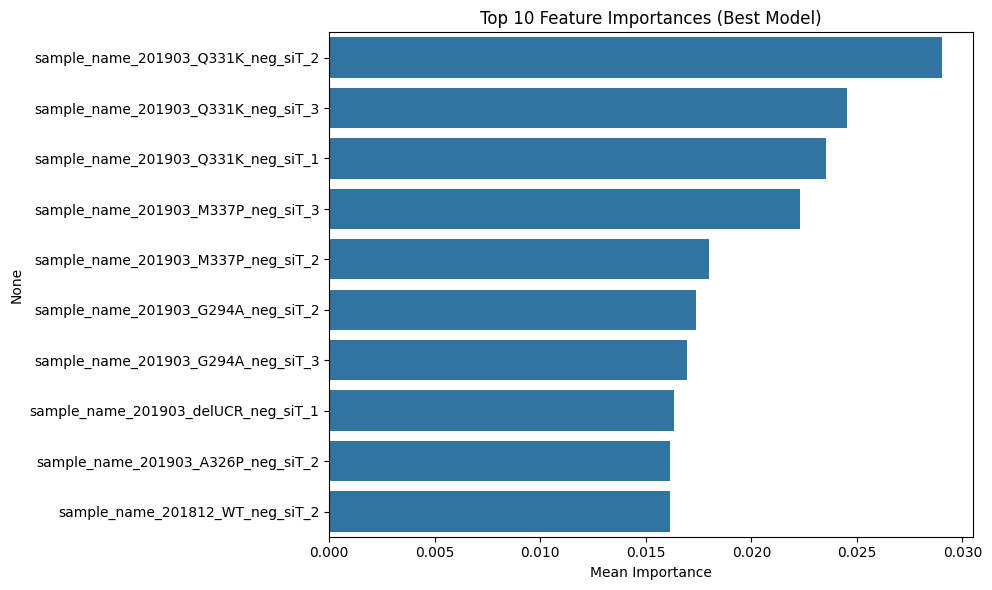

In [5]:
"""
cross validation 
"""
# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (30, 15)],
    'alpha': [0.0001, 0.001, 0.01],
    'early_stopping': [True]
}

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Use the best estimator found
best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

# Evaluate best model
y_pred_best = best_model.predict(X_test)
print("Confusion Matrix (Best Model):\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred_best))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix (Best Neural Network)")
plt.show()

# ROC Curve for best model (if binary classification)
if len(le.classes_) == 2:
    y_prob_best = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_best)
    auc_score_best = roc_auc_score(y_test, y_prob_best)

    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score_best:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Best Model)")
    plt.legend()
    plt.show()

# --- Permutation Feature Importance using best model ---
perm_importance_best = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Top 10 features
sorted_idx_best = perm_importance_best.importances_mean.argsort()[-10:][::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x=perm_importance_best.importances_mean[sorted_idx_best],
    y=X.columns[sorted_idx_best]
)
plt.title("Top 10 Feature Importances (Best Model)")
plt.xlabel("Mean Importance")
plt.tight_layout()
plt.show()
